# Chapter 4: Bayesian Statistics in pymc3 (Working in progress proof of concept)

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing gempy
import gempy as gp


# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000-10000,747000 + 20600,6863000 - 20600,6950000 + 20600,-20000, 600],[10, 10, 10],
                         path_o = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

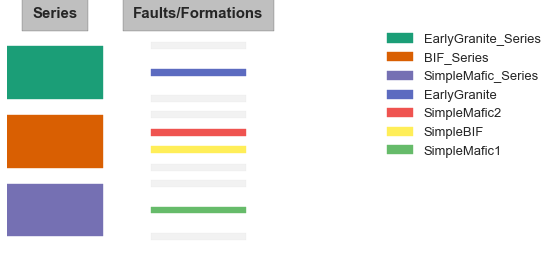

In [3]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2', 'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

Setting uncertainties adding the values to the Dataframe.

In [5]:
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = 0
geo_data.interfaces['Z_std'] = 100

geo_data.orientations['X_std'] = None
geo_data.orientations['Y_std'] = 0
geo_data.orientations['Z_std'] = 100

geo_data.orientations['dip_std'] = 10
geo_data.orientations['azimuth_std'] = 10
geo_data.orientations.head()

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,X_std,Y_std,Z_std,dip_std,azimuth_std,order_series,isFault,formation number,annotations
0,722403.8130,6880913.25,470.707065,0.819295,-0.546444,0.173648,80.0,123.702047,1,EarlyGranite,EarlyGranite_Series,None,0,100,10,10,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$"
1,718928.3440,6883605.50,509.462245,0.063997,-0.982726,0.173648,80.0,176.274084,1,EarlyGranite,EarlyGranite_Series,None,0,100,10,10,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},1}$"
2,720690.5630,6882822.25,489.909423,-0.948735,-0.264099,0.173648,80.0,254.444427,1,EarlyGranite,EarlyGranite_Series,None,0,100,10,10,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},2}$"
3,721229.0005,6880766.25,477.680894,-0.955039,-0.240305,0.173648,80.0,255.876557,1,EarlyGranite,EarlyGranite_Series,None,0,100,10,10,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},3}$"
4,710459.8440,6880521.50,511.839758,-0.782956,-0.597348,0.173648,80.0,232.658556,1,EarlyGranite,EarlyGranite_Series,None,0,100,10,10,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},4}$"


## Real gravity

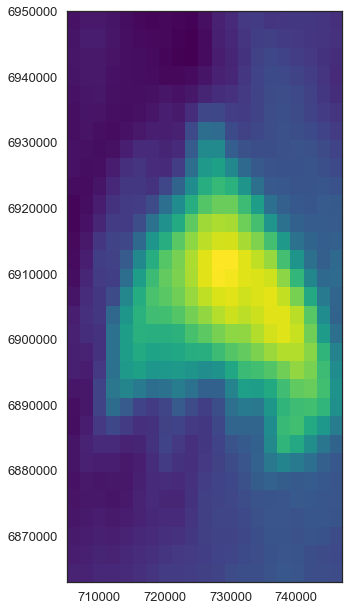

In [6]:
import matplotlib.pyplot as plt
import pandas as pn
grav_real = pn.read_csv('../input_data/Sst_grav_2000.xyz', header=None, names = ['X', 'Y', 'N', 'G'], delim_whitespace=True)
plt.imshow(grav_real['G'].values.reshape(31,21), extent=[7.050000e+05,747000,6863000,6950000], origin='lower', cmap='viridis')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [7]:
# Calibration parameters
# F_min, F_max =  np.min(Forw), np.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
# F_range = F_max - F_min
# F_mid = 0.5*(F_max+F_min)

rs_min, rs_max = np.min(grav_real['G']), np.max(grav_real['G'])
rs_range = rs_max - rs_min
rs_mid = 0.5*(rs_max+rs_min)

#Rescaling

# rs_mid + (grid - m_mid) / m_range * rs_range
# Reescaled_forw = rs_mid + (Forw - F_mid) / F_range * rs_range

In [8]:
import theano
grav_real_mid = theano.shared(rs_mid, 'Grav_real_mid')
grav_real_range = theano.shared(rs_range, 'Grav_real_range')
grav_real_th = theano.shared(grav_real['G'].as_matrix())

In [9]:
grav_real_th.get_value().shape

(651,)

In [10]:
# input_data_T = interp_data.interpolator.tg.input_parameters_list()
# input_data_P = interp_data.get_input_data(u_grade=[3, 3])
# select = interp_data.interpolator.pandas_rest_layer_points['formation'] == 'Reservoir'

In [11]:
interp_data_grav = gp.InterpolatorInput(geo_data, output='gravity', compile_theano=False, dtype='float64',
                                   u_grade=[3, 3, 3])

AttributeError: module 'gempy' has no attribute 'InterpolatorInput'

In [20]:
gp.set_geophysics_obj(interp_data_grav,  [7.050000e+05,747000,6863000,6925000,-20000, 200],
                                             [31,21])

NameError: name 'interp_data_grav' is not defined

In [12]:
a,b = gp.precomputations_gravity(interp_data_grav, 24, [2.92, 3.1, 2.92, 2.61, 2.61])

Now the generation of the geomodel will be an operation embedded in a larger tree.

In [13]:
# import theano
# import theano.tensor as T
# geomodel = theano.OpFromGraph(interp_data_grav.interpolator.tg.input_parameters_list(),
#                               interp_data_grav.interpolator.tg.compute_geological_model(n_faults=0, compute_all=True),
#                               on_unused_input='ignore',
#                             )

In [14]:
g = interp_data_grav.interpolator.tg.input_parameters_list()[0]
g.type

TensorType(float64, matrix)

In [15]:
interp_data_grav.interpolator.tg.n_formation.get_value().dtype

dtype('int64')

In [11]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(interp_data_grav.interpolator.tg.input_parameters_list(),
                              [interp_data_grav.interpolator.tg.compute_forward_gravity(n_faults=0, compute_all=True)],
                              on_unused_input='ignore',
                            )

Because now the GeMpy model is a theano operation and not a theano function, to call it we need to use theano variables (with theano functions we call them with python variables). This is very easy to modify, we just need to use theano shared to convert our python input data into theano variables.

The pymc3 objects are already theano variables (pm.Normal and so on). Now the trick is that using the theano function T.set_subtensor, we can change one deterministic value of the input arrays(the ones printed in the cell above) by a stochastic pymc3 object. Then with the new arrays we just have to call the theano operation and pymc will do the rest

In [ ]:
# This is the creation of the model
import pymc3 as pm

theano.config.compute_test_value = 'warn'
dtype='float64'
#theano.config.warn_float64 = 'warn'
model = pm.Model()
with model:
    # We create the Stochastic parameters. In this case only the Z position
    # of the interfaces
    Z_rest = pm.Normal('Z_unc_rest',
       interp_data_grav.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
       interp_data_grav.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'),
                  dtype=dtype, shape = (66))
    
    Z_ref = pm.Normal('Z_unc_ref', interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z'].as_matrix().astype('float32'),
              interp_data_grav.interpolator.pandas_ref_layer_points_rep['Z_std'].as_matrix().astype('float32'),
              dtype=dtype, shape = (66))
    
    dip_unc = pm.Normal('dip_unc', interp_data_grav.geo_data_res.foliations['dip'].as_matrix(),
                        interp_data_grav.geo_data_res.foliations['dip_std'].as_matrix(),
                       dtype=dtype, shape = (41))
    
    azimuth_unc = pm.Normal('azimuth_unc', interp_data_grav.geo_data_res.foliations['azimuth'].as_matrix(), 
                            interp_data_grav.geo_data_res.foliations['azimuth_std'].as_matrix(),
                       dtype=dtype, shape = (41))
    
#     Z_unc = pm.Normal('Z_unc', interp_data_grav.geo_data_res.interfaces['Z'].astype('float32'),
#                       interp_data_grav.geo_data_res.interfaces['Z_std'].astype('float32'), dtype='float32', shape= (70))
    
#     interp_data_grav.geo_data_res.interfaces['Z'] = Z_unc
    
    # We convert a python variable to theano.shared
    input_sh = []
    for i in interp_data_grav.get_input_data():
        input_sh.append(theano.shared(i))
    
    # We add the stochastic value to the correspondant array. rest array is
    # a n_points*3 (XYZ) array. We only want to change Z in this case.
    input_sh[4] = T.set_subtensor(
    input_sh[4][:, 2], Z_ref)

    input_sh[5] = T.set_subtensor(
    input_sh[5][:, 2], Z_rest)
    
    # With the stochastic parameters we create the geomodel result:
    Forw = pm.Deterministic('GemPy', geomodel(input_sh[0], input_sh[1], input_sh[2],
                                                   input_sh[3], input_sh[4], input_sh[5]))
    
    # Calibration parameters
    F_min, F_max =  T.min(Forw), T.max(Forw)   #36.630742, 36.651496    #30.159309, 30.174104#
    F_range = F_max - F_min
    F_mid = 0.5*(F_max+F_min)
    
    Reescaled_forw = grav_real_mid + (Forw - F_mid) / F_range * grav_real_range
    
    e_sq = T.sqrt(T.sum(T.square(Reescaled_forw - (grav_real_th))))

    Y_obs = pm.HalfCauchy('Y_obs', beta=e_sq, observed=1000)

In [ ]:
%debug

In [ ]:
#import theano.tensor as T
#import pymc3 as pm
#pm.HalfCauchy?

In [ ]:
theano.config.compute_test_value = 'off'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG 
# THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    step = pm.NUTS()
    trace = pm.sample(30, tune=10, init=None, step=step, )

In [ ]:
%debug

In [ ]:
trace.get_values('GemPy')[5] -  trace.get_values('GemPy')[15]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trace.get_values('GemPy')[-10].reshape(50,50), cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000] )
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt
for i in range(100):
    gp.plot_section(geo_data, trace.get_values('GemPy')[i][0, :], 18,
                       direction='y', plot_data=False)
    plt.show()

In [ ]:
from theano.printing import pydotprint

pydotprint(model.logpt)